In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from gpzoo.kernels import MGGP_NSF_RBF
from gpzoo.gp import MGGP_NSF
import squidpy as sq
import numpy as np
from gpzoo.utilities import train, train_batched

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [3]:
new_model=False
model_name = 'slideseq_mggp'

In [4]:
adata = sq.datasets.slideseqv2()
Y_sums = np.array(np.sum(adata.raw.X > 0, axis=0))[0]
Y = np.array(adata.raw.X[:, Y_sums>1000].todense() * 1000, dtype=int).T

In [5]:
X = adata.obsm['spatial']

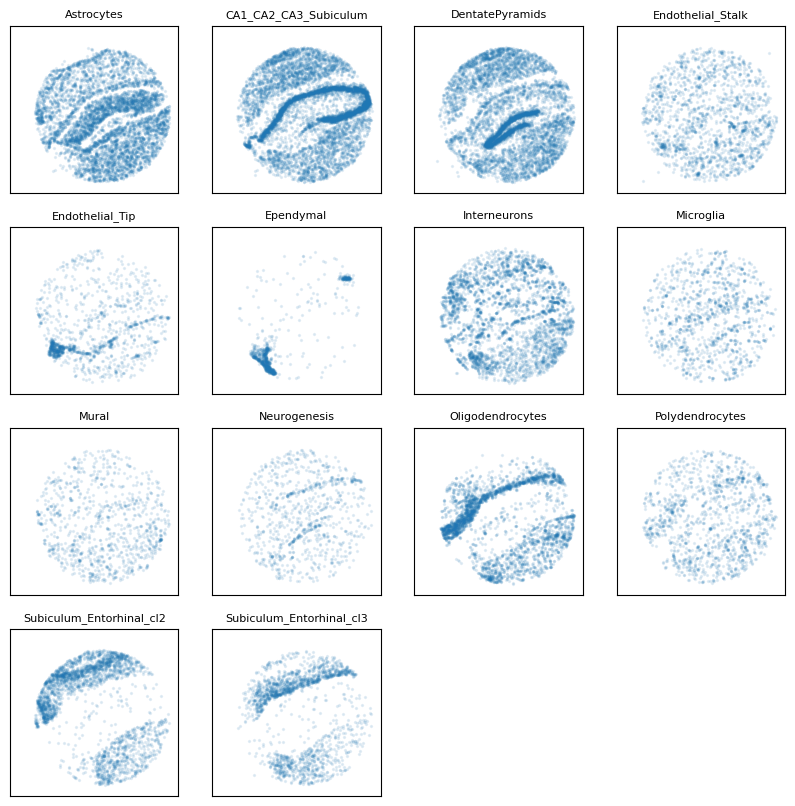

In [6]:
plt.figure(figsize=(10, 10))
for i, category in enumerate(adata.obs.cluster.values.categories):
    mask = adata.obs.cluster.values==category
    plt.subplot(4, 4, i+1)
    plt.title(category, fontsize=8)
    plt.scatter(adata.obs.x[mask], adata.obs.y[mask], alpha=0.1, s=2)
    plt.xlim([0, 6000])
    plt.ylim([0, 6000])
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])

In [7]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [8]:
X.shape

torch.Size([41786, 2])

In [9]:
Y.shape

torch.Size([5899, 41786])

In [10]:
L =10
M = 300
groupsX = torch.tensor(adata.obs.cluster.values.codes).type(torch.LongTensor)
n_groups = len(adata.obs.cluster.values.categories)

kernel = MGGP_NSF_RBF(sigma=2.0, lengthscale=5.0, group_diff_param=5.0, n_groups=n_groups, device=device)

model = MGGP_NSF(X=X, y=Y, kernel=kernel, M=M, L=L, jitter=1e-2, n_groups=n_groups)

idz = torch.multinomial(torch.ones(X.shape[0]), num_samples=M*n_groups, replacement=False)
model.svgp.Z = nn.Parameter(X[idz])
model.svgp.groupsZ = (groupsX[idz].clone()).to(device)



In [11]:
# model = torch.load('slideseq_mggp')
model.to(device)


MGGP_NSF(
  (svgp): MGGP_SVGP(
    (kernel): MGGP_NSF_RBF()
  )
)

In [12]:
#freeze kernel parameters first, unfreeze for finetunning
model.svgp.kernel.lengthscale.requires_grad = False
model.svgp.kernel.group_diff_param.requires_grad = False
model.svgp.kernel.sigma.requires_grad = False

In [13]:
X_train = X.to(device)
Y_train = Y.to(device)
groupsX = groupsX.to(device)

In [14]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
losses = train_batched(model, optimizer, X_train, groupsX, Y_train, device, steps=2000, batch_size=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

(1000000000.0, 1500000000.0)

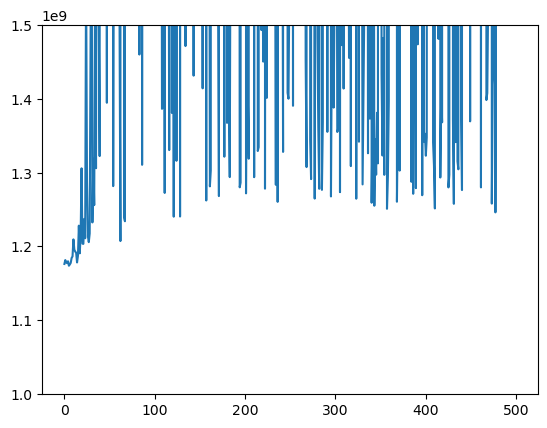

In [44]:
plt.plot(losses)
plt.ylim([1e9, 0.15*1e10])

In [39]:
torch.save(model, 'slideseq_mggp')

In [45]:
print('lengthscale:', model.svgp.kernel.lengthscale)
print('sigmas:', model.svgp.kernel.sigma)
print('group_diff_params', torch.round(model.svgp.kernel.group_diff_param, decimals=2))

lengthscale: Parameter containing:
tensor([[[7.0556]],

        [[6.2336]],

        [[6.1673]],

        [[6.8495]],

        [[5.7313]],

        [[6.6472]],

        [[6.0107]],

        [[5.9713]],

        [[5.9097]],

        [[6.3493]]], device='cuda:1', requires_grad=True)
sigmas: Parameter containing:
tensor([[[0.9872]],

        [[1.0342]],

        [[0.9200]],

        [[1.1237]],

        [[1.1530]],

        [[1.0956]],

        [[1.0610]],

        [[1.0589]],

        [[1.1444]],

        [[0.9362]]], device='cuda:1', requires_grad=True)
group_diff_params tensor([[[8.1100]],

        [[8.1600]],

        [[8.0200]],

        [[8.3500]],

        [[7.7900]],

        [[8.2600]],

        [[8.1400]],

        [[7.9200]],

        [[8.3400]],

        [[8.0800]]], device='cuda:1', grad_fn=<RoundBackward1>)


In [46]:
idx = torch.multinomial(torch.ones(len(X_train)), num_samples=5000, replacement=False)
qF, qU, pU = model.svgp(X_train[idx], groupsX[idx])
loadings = torch.exp(qF.mean).detach().cpu().numpy()
del qF, qU, pU
with torch.no_grad():
    if device.type=='cuda':
        torch.cuda.empty_cache()

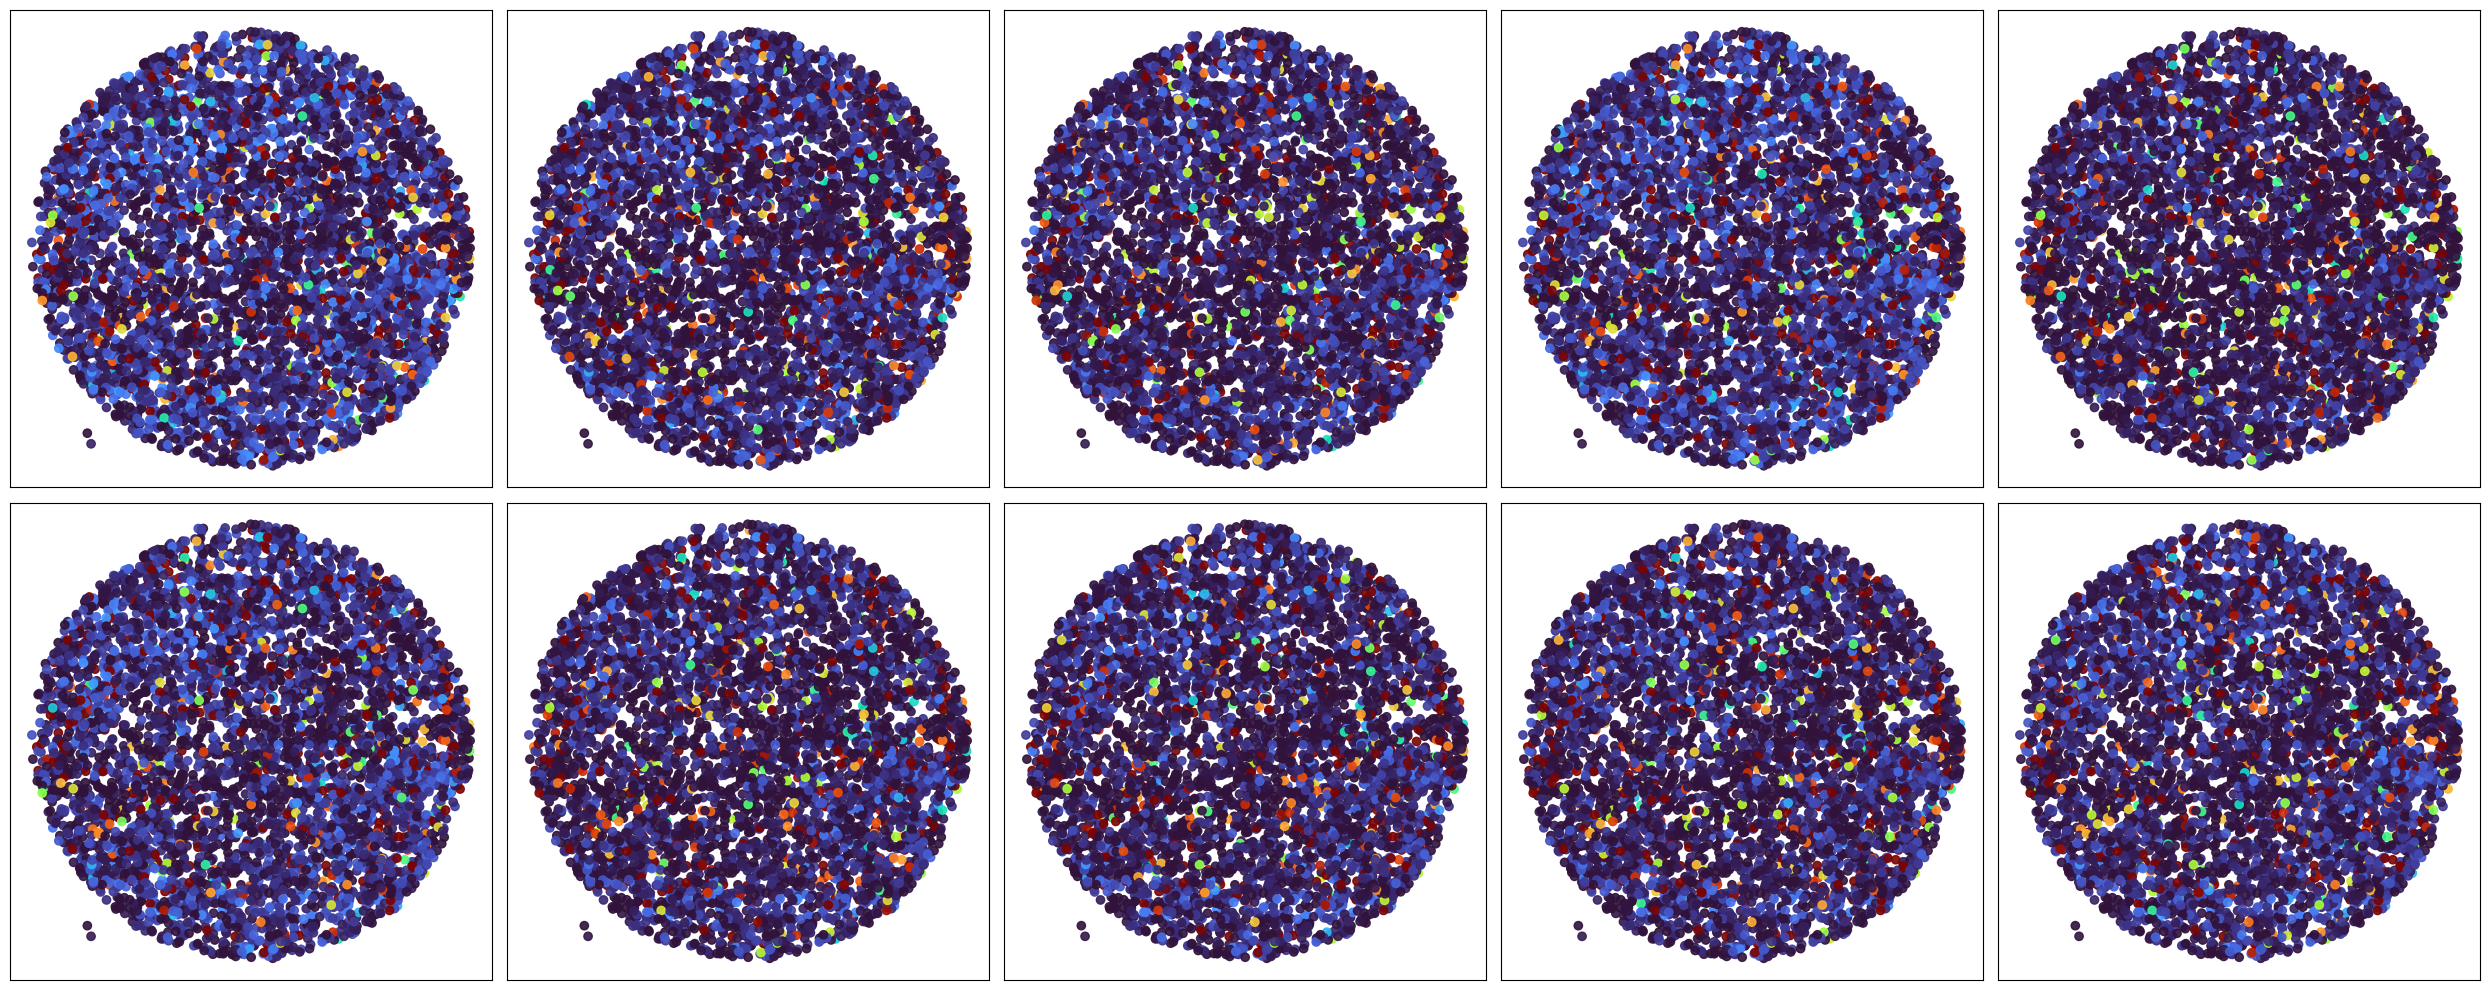

In [47]:
max_val = np.percentile(loadings, 95)
min_val = np.percentile(loadings, 5)


size = 5
plt.figure(figsize=(size*5, size*2), tight_layout=True)
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    plt.scatter(X[idx, 0], X[idx,1], c=loadings[i], vmin=min_val, vmax=max_val, alpha=0.9, cmap='turbo')

    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])

In [51]:
model.svgp.kernel.embedding @ model.svgp.kernel.embedding.T

tensor([[ 0.4643, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357,
         -0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357],
        [-0.0357,  0.4643, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357,
         -0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357],
        [-0.0357, -0.0357,  0.4643, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357,
         -0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357],
        [-0.0357, -0.0357, -0.0357,  0.4643, -0.0357, -0.0357, -0.0357, -0.0357,
         -0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357],
        [-0.0357, -0.0357, -0.0357, -0.0357,  0.4643, -0.0357, -0.0357, -0.0357,
         -0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357],
        [-0.0357, -0.0357, -0.0357, -0.0357, -0.0357,  0.4643, -0.0357, -0.0357,
         -0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357],
        [-0.0357, -0.0357, -0.0357, -0.0357, -0.0357, -0.0357,  0.4643, -0.0357,
         -0.0357, -0.0357, -0.0357, -0.0357, -0.0